In [19]:
import torch
import pandas as pd
import numpy as np
import tqdm
import torch.nn as nn
import argparse
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# from pykrx import stock
# df = stock.get_market_ohlcv("20220613","20230612","048410")
# df.to_csv('./data/현대바이오.csv')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, layers, output_size, normal_data):
        super(LSTMModel, self).__init__()
        torch.manual_seed(2023)
        self.normal_data = normal_data
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        ouputs, status = self.lstm(input)
        x = self.linear(ouputs[:, -1])
        return x
    
    def predict(self):
        step = self.hidden_size
        input_data = self.normal_data[-step:]
        print(f'input_data: {input_data.shape}')
        return self.forward(torch.Tensor([input_data]))

# many to many(x_count수를 input으로 output_size개를 예측)
def split_train(data, x_count, output_size):
    data = data.tolist()
    x_train = []
    for i in range(0, len(data)-x_count-output_size+1):
        x_train.append([[j] for j in data[i:i+x_count]])

    # y_train = [[i] for i in data[x_count:]]
    y_train = []
    for i in range(x_count, len(data)-output_size+1):
        y_train.append(data[i:i+output_size])

    return torch.Tensor(x_train), torch.Tensor(y_train)

In [5]:
"""
many to many 평가
"""
# 하이퍼 파라미터
input_size = 1
hidden_size = 10
layers = 1
output_size = 5
learning_rate = 0.01
epoch = 300

df = pd.read_csv('./data/20230615_현대바이오.csv')
# x_train, y_train = split_train(np.ravel(df['시가'].values), 4)
# print(df['시가'][:10])
# print(x_train[:10])
# print(y_train[:10])
mms = MinMaxScaler()
normal = mms.fit_transform(df[['시가']])
# train, test 데이터 나누기
normal90, normal10 = np.split(normal, [int(len(normal)*0.9)])
x_train, y_train = split_train(np.ravel(normal90), hidden_size, output_size)
print(x_train.shape)
print(y_train.shape)
x_test, y_test = split_train(np.ravel(normal10), hidden_size)

model = LSTMModel(input_size, hidden_size, layers, output_size, normal)

cost = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_value=[]
for i in range(epoch + 1):
    prediction = model(x_train)
    output = cost(prediction, y_train)
    loss_value.append(output)

    optimizer.zero_grad()
    output.backward()
    optimizer.step()

print(loss_value[-10:])
predict_test = model(x_test)
predict_test = mms.inverse_transform(predict_test.tolist())
y_test = mms.inverse_transform(y_test.tolist())
# 시점을 맞춰서 보기 
# predict_test = np.delete(predict_test, 0)
# y_test = np.delete(y_test, -1)
# print(y_test)
# print(predict_test)

plt.plot(np.ravel(y_test), ".-", label='label')
plt.plot(np.ravel(predict_test), ".-", label="predict")
plt.legend()

torch.Size([210, 10, 1])
torch.Size([210, 5])


TypeError: split_train() missing 1 required positional argument: 'output_size'

[tensor(0.0105, grad_fn=<MseLossBackward0>), tensor(0.0105, grad_fn=<MseLossBackward0>), tensor(0.0104, grad_fn=<MseLossBackward0>), tensor(0.0104, grad_fn=<MseLossBackward0>), tensor(0.0103, grad_fn=<MseLossBackward0>), tensor(0.0103, grad_fn=<MseLossBackward0>), tensor(0.0103, grad_fn=<MseLossBackward0>), tensor(0.0102, grad_fn=<MseLossBackward0>), tensor(0.0102, grad_fn=<MseLossBackward0>), tensor(0.0101, grad_fn=<MseLossBackward0>)]
input_data: (10, 1)


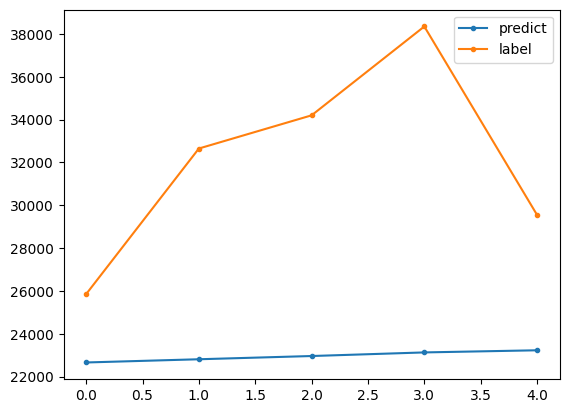

In [37]:
"""
예측값 보기
"""
input_size = 1
hidden_size = 10
layers = 1
output_size = 5
learning_rate = 0.01
epoch = 100

df = pd.read_csv('./data/현대바이오 copy.csv')
mms = MinMaxScaler()
normal = mms.fit_transform(df[['시가']])
x_train, y_train = split_train(np.ravel(normal), hidden_size, output_size)

model = LSTMModel(input_size, hidden_size, layers, output_size, normal)
cost = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_value=[]
for i in range(epoch + 1):
    prediction = model(x_train)
    output = cost(prediction, y_train)
    loss_value.append(output)

    optimizer.zero_grad()
    output.backward()
    optimizer.step()
print(loss_value[-10:])

# 추론
result = model.predict()

result = mms.inverse_transform(result.tolist())
plt.plot(result[0], '.-', label='predict')
df2 = pd.read_csv('./data/20230615_현대바이오.csv')
plt.plot(df2['시가'][-output_size:].values, '.-', label='label')
plt.legend()